# Notebook Details

This notebook contains preliminary checks and tests which must be conducted before a timeseries can be forecasted.

1. Stationarity
    - Visual inspection
    - Rolling statistics
    - Statistical Test: Augmented Dickey-Fuller (ADF)
3. Autocorrelation
    - Autocorrelation Function (ACF)
    - Partial Autocorrelation Function (PACF)
    - Durbin-Watson Test

# Stationarity

A time series is stationary if its mean, variance, and autocorrelation do not change over time.
In other words, the series shouldn’t drift, trend, or change volatility over time.

**✅ Why Do We Care?**

Many models like ARIMA assume stationarity. If the series is not stationary, predictions will be unreliable or biased.


| Method        | What It Checks           | How to Interpret                  |
| ------------- | ------------------------ | --------------------------------- |
| Plotting      | Visual trend/variance    | No trend/constant variance = good |
| Rolling stats | Changing mean/std        | Flat = good                       |
| ADF Test      | Statistical stationarity | p-value < 0.05 = stationary       |


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
df = pd.read_csv('../input/delhi-weather-data/testset.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')
df.rename(columns={col : col.strip() for col in df.columns}, inplace=True)
df.head()

,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
datetime_utc,,,,,,,,,,,,,,,,,,,
1996-11-01 11:00:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1996-11-01 12:00:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 13:00:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 14:00:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
1996-11-01 16:00:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [2]:
df = df[['_tempm']]

## How to Check for Stationarity

### Visual Inspection

* Look for trend, seasonality, or changing variance.
* If you see any of these — not stationary.



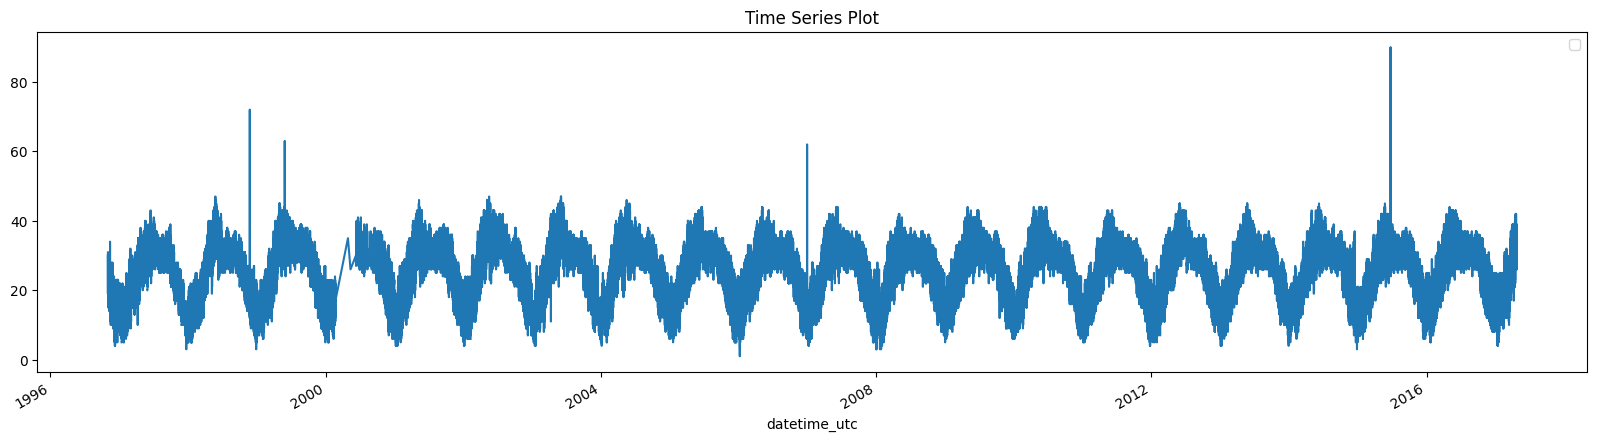

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df.plot(figsize=(20, 5))
plt.title("Time Series Plot")
plt.show()


### Rolling Statistics

* Check if mean/variance change over time.
* If lines are flat, you're good.
* If they change, it's likely non-stationary.

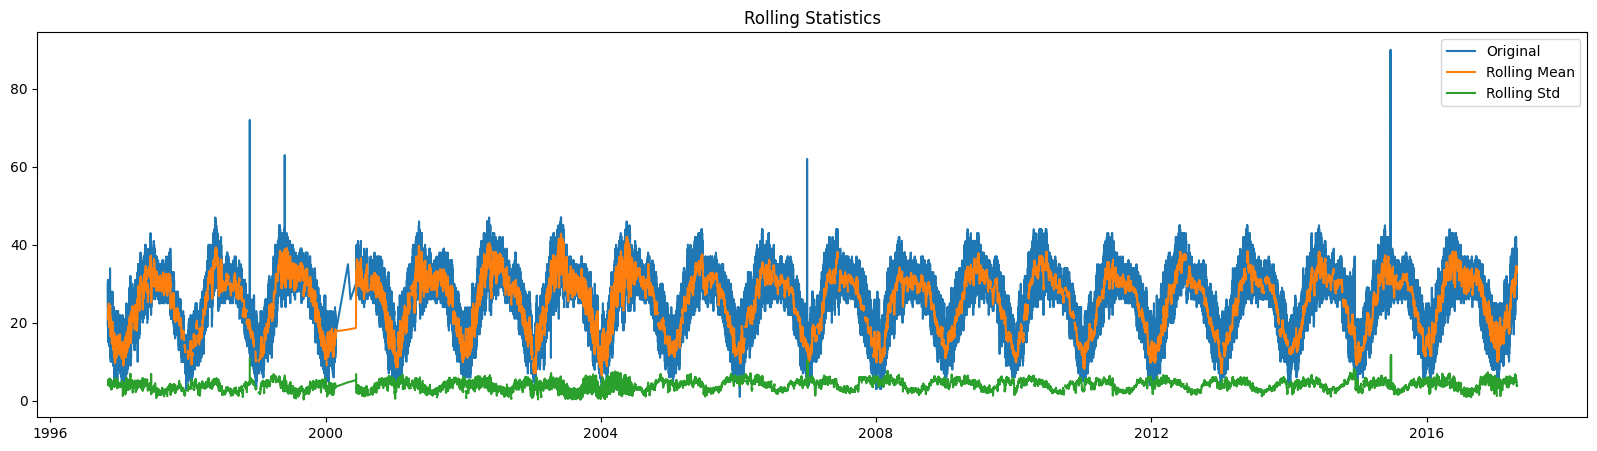

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))

roll_mean = df.rolling(window=30).mean()
roll_std = df.rolling(window=30).std()

plt.plot(df, label='Original')
plt.plot(roll_mean, label='Rolling Mean')
plt.plot(roll_std, label='Rolling Std')
plt.legend()
plt.title("Rolling Statistics")
plt.show()

### Statistical Test: Augmented Dickey-Fuller (ADF)

The ADF test is a statistical hypothesis test used to check whether a time series is stationary or non-stationary.
It tells you if your time series has a unit root — which means it's non-stationary.



| Hypothesis           | Meaning                                          |
| -------------------- | ------------------------------------------------ |
| **H₀ (null)**        | The series **is non-stationary** (has unit root) |
| **H₁ (alternative)** | The series **is stationary** (no unit root)      |

**⚙️ How Does It Work (Intuition)**

Imagine you're modeling a time series like this:

    y[t] = ρ ∗ y[t−1] + ε[t]

* y[t] = current value
* ρ = autoregressive coefficient
* ε[t] = white noise (random error)

**Case 1: ρ = 1**
    
    y[t] = y[t−1] + ε[t]

* This is a random walk.
* The variance keeps increasing over time → non-stationary.
* Such a series has a unit root.

**Case 2: |ρ| < 1**

    y[t] = 0.8 ∗ y[t−1] + ε[t]

* The series fluctuates around a stable mean.
* Variance stays bounded → stationary.


If ρ = 1, the series has a unit root → it’s non-stationary.
ADF tests whether ρ = 1 or not.

Augmented Part - The "augmented" part means it includes lagged values of the difference to account for autocorrelation (to make the test more reliable).



**🧠 Interpretation:**
* p-value < 0.05 → Reject null hypothesis → Stationary
* p-value > 0.05 → Fail to reject → Non-stationary

In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.dropna())
statistic, p_val, num_lags, num_observation = result[0:4]

print(f"ADF Statistic: {statistic}")  # Test value; more negative = stronger evidence of stationarity
print(f"p-value: {p_val}")
print(f"Number of Lags used: {num_lags}")
print(f"Number of Observation used: {num_observation}")

if p_val < 0.05:
    print('timeseries is >> stationary <<')
else: 
    print('timeseries is >> non-stationary <<')

ADF Statistic: -7.59168265620477
p-value: 2.521665336728154e-11
Number of Lags used: 68
Number of Observation used: 100248
timeseries is >> stationary <<


# Autocorrelation

Autocorrelation measures how much past values influence current values in a time series.

Think of it like:
* “Is the value today similar to yesterday? Or 7 days ago?”
* If yes, the series has autocorrelation — it remembers its past.

**🔍 Why Verify Autocorrelation?**
* Forecasting relies on autocorrelation — models like ARIMA or LSTM learn from patterns in past data.
* If there's no autocorrelation, simple models may work better than complex ones.

## How to Check for Autocorrelation

### Plot the Autocorrelation Function (ACF)

This shows correlation between the series and its lagged versions. 
<pre>
ACF os like a loop checking correlation at each lag
</pre>

**🔍 How to Read ACF Plot:**

* X-axis: Lag (e.g., 1 = yesterday, 7 = last week)
* Y-axis: Correlation coefficient (-1 to 1)
* Bars: Show strength of correlation at each lag
* Blue shaded area: 95% confidence interval
    * Bars outside this = significant autocorrelation

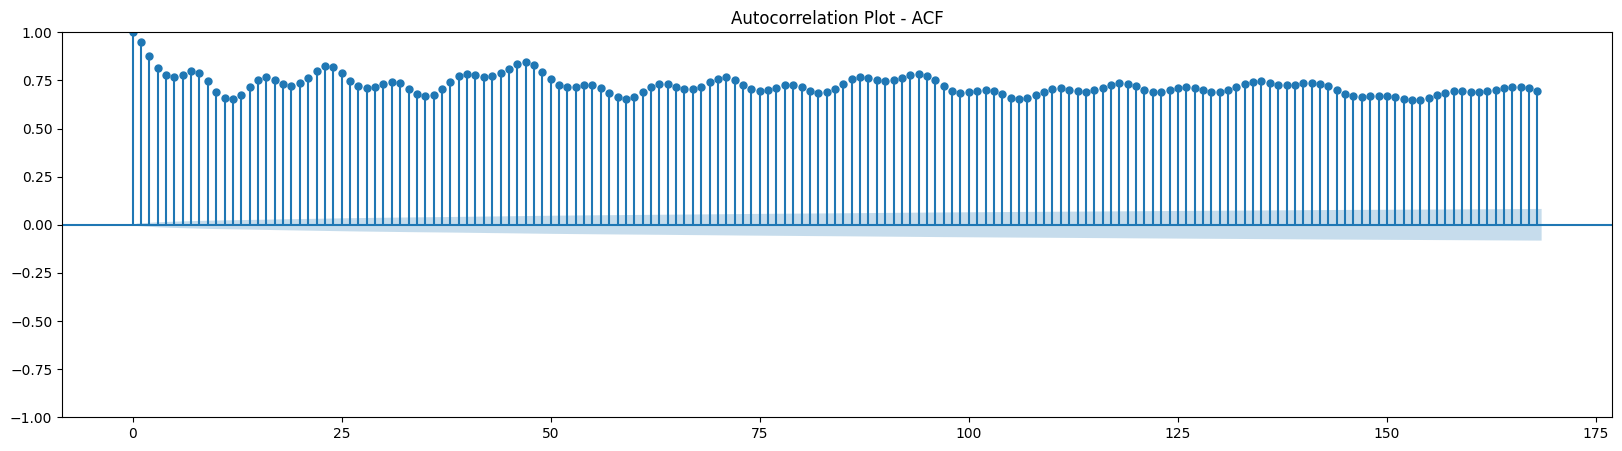

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fix, ax = plt.subplots(1, 1, figsize=(20, 5))
plot_acf(df.dropna(), lags=168, ax=ax)  # check up to 100 time lags
plt.title("Autocorrelation Plot - ACF")
plt.show()

### Plot the Partial Autocorrelation Function (PACF)

PACF shows direct effect of lag, removing intermediate lags’ influence.

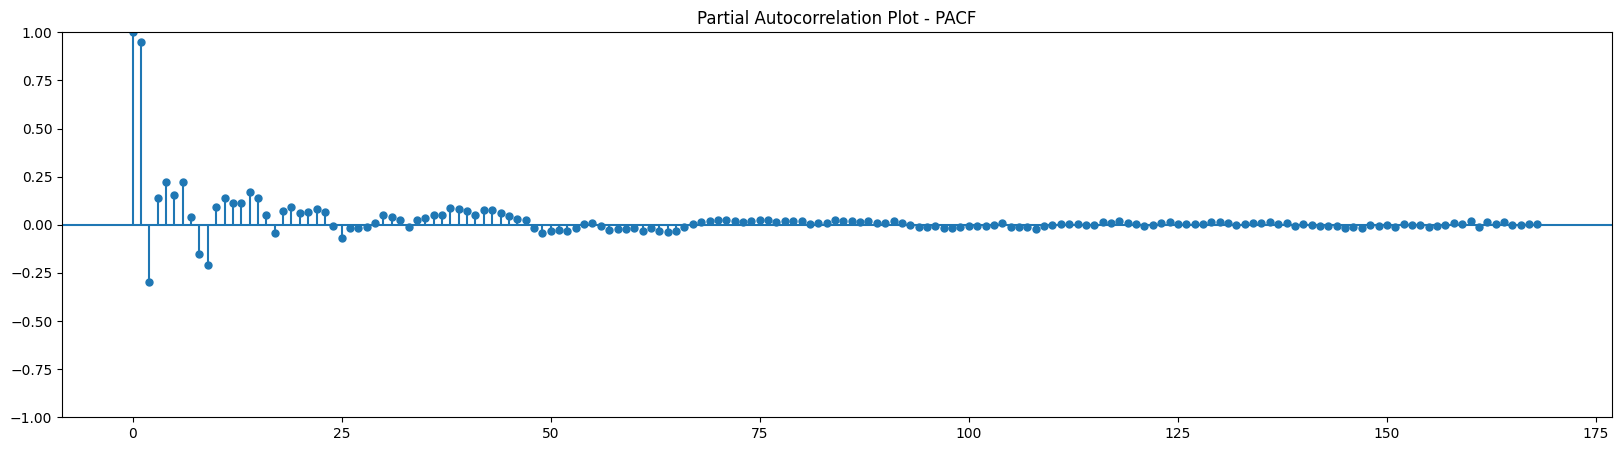

In [7]:
# Plot autocorrelation
fix, ax = plt.subplots(1, 1, figsize=(20, 5))
plot_pacf(df.dropna(), lags=168, ax=ax)  # check up to 100 time lags
plt.title("Partial Autocorrelation Plot - PACF")
plt.show()

### Durbin-Watson Test

The Durbin-Watson statistic is a test for autocorrelation in the residuals (errors) of a regression or time series model.

**🔍 When and Why Use Durbin-Watson?**
* Autocorrelation violates a key assumption of many models (e.g., linear regression, ARIMA).
* If errors are autocorrelated, your model may give biased results or poor forecasts.
* DW is especially useful after fitting a model, to check residuals.

**🔢 Durbin-Watson Formula**
Let’s say you have residuals e₁, e₂, ..., eₙ from a model.

The DW statistic is computed as:
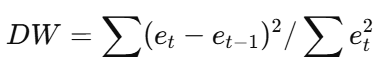

Where:
* Numerator: Sum of squared differences between consecutive residuals.
* Denominator: Sum of squared residuals.

**⚠️ Limitations of Durbin-Watson**
* Only checks lag-1 autocorrelation.
* Not good for seasonal autocorrelation (e.g., weekly or monthly lags).
* Assumes linear model residuals.
* Not suitable for nonlinear models (like neural nets) directly — but you can still apply it to residuals.

**🧠 Interpretation**

| DW Value | Interpretation                  |
| -------- | ------------------------------- |
| ≈ 2      | **No autocorrelation** ✅        |
| < 2      | **Positive autocorrelation** ❌  |
| > 2      | **Negative autocorrelation** ❌  |
| ≈ 0      | Strong positive autocorrelation |
| ≈ 4      | Strong negative autocorrelation |

In [8]:
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(df.dropna())

statistic = dw_stat[0]
print(f"Durbin-Watson statistic: {statistic}")

if statistic == 2:
    print('>> No autocorrelation <<')
elif statistic < 2:
    print('>> Positive autocorrelation <<')
else:
    print('>> Negative autocorrelation <<')

Durbin-Watson statistic: 0.009634257891992518
>> Positive autocorrelation <<


**✅ When to Use DW vs. ACF/PACF?**

| Test         | What It Detects                  | When to Use                              |
| ------------ | -------------------------------- | ---------------------------------------- |
| **DW**       | Autocorrelation in **residuals** | After fitting model, check model quality |
| **ACF/PACF** | Autocorrelation in **raw data**  | Before modeling, to understand patterns  |
